# Getting Started with EDA on Time Series Data

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In [2]:
raw_data_df = pd.read_csv('../../../data/sample_data_1.csv')

raw_data_df.head()

date  media     sales
0  2018-01-03    0.0  6.258472
1  2018-01-04    0.0  6.170889
2  2018-01-05    0.0  5.754669
3  2018-01-06    0.0  5.968413
4  2018-01-07    0.0  5.285262

In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1367 non-null   object 
 1   media   1367 non-null   float64
 2   sales   1275 non-null   float64
dtypes: float64(2), object(1)
memory usage: 32.2+ KB


## Data Preparation

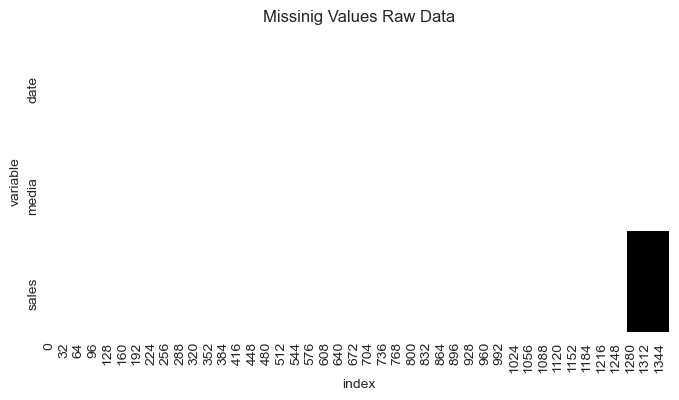

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(data=raw_data_df.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missinig Values Raw Data', xlabel='index', ylabel='variable');

In [5]:
data_df = raw_data_df \
    .copy() \
    .query('sales.notnull()') \
    .assign(
        date = lambda x: pd.to_datetime(x['date']),
        year = lambda x: x['date'].dt.year,
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        dayofyear = lambda x: x['date'].dt.dayofyear,
    )

data_df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 0 to 1274
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1275 non-null   datetime64[ns]
 1   media      1275 non-null   float64       
 2   sales      1275 non-null   float64       
 3   year       1275 non-null   int64         
 4   month      1275 non-null   int64         
 5   day        1275 non-null   int64         
 6   dayofyear  1275 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 79.7 KB


## Data Visualization

### Aggregations

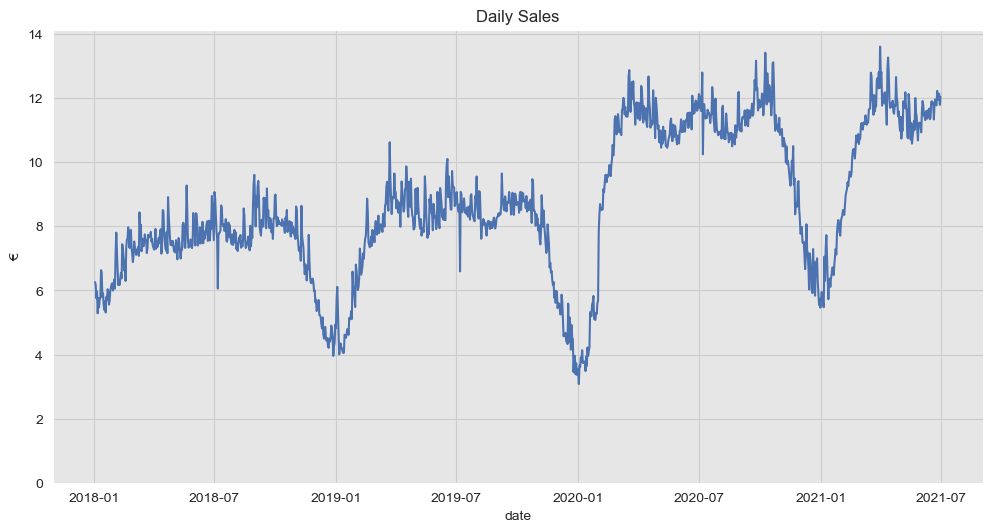

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales', data=data_df, color=sns_c[0], ax=ax)
ax.set(title='Daily Sales', xlabel='date', ylabel='€', ylim=(0, None));

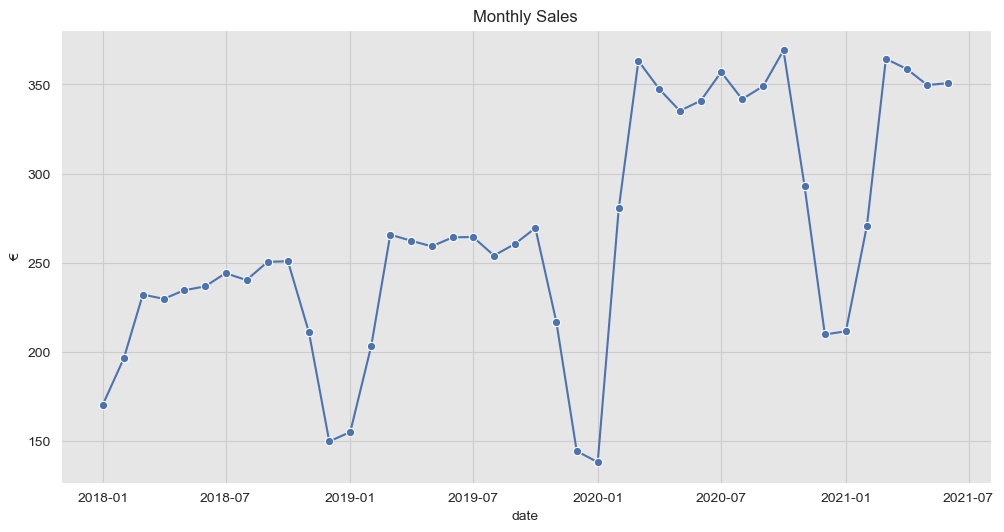

In [7]:
fig, ax = plt.subplots()
data_df \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .assign(
        date = lambda x: pd.to_datetime(x['year'].astype('str') + '-' + x['month'].astype('str') + '-01')
    ) \
    .pipe((sns.lineplot, 'data'), 
        x='date', 
        y='sales', 
        marker='o',
        ax=ax
    )
ax.set(title='Monthly Sales', ylabel='€');

### Distributions

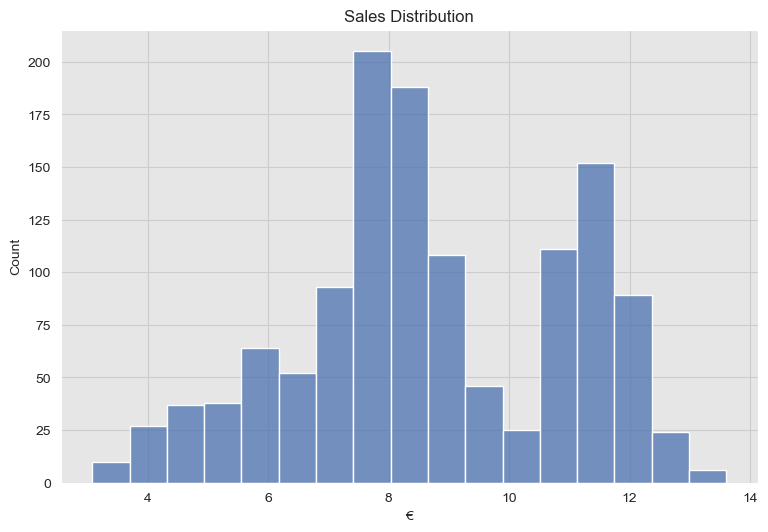

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(x='sales', data=data_df, ax=ax)
ax.set(title='Sales Distribution', xlabel='€');

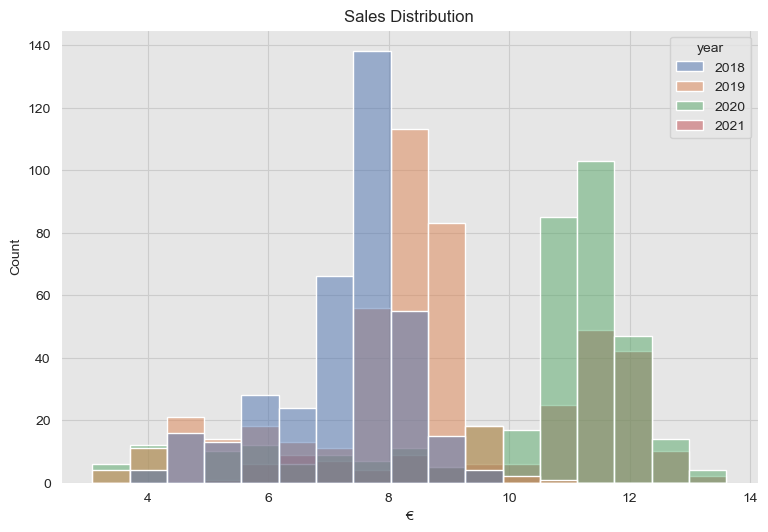

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(
    x='sales', 
    data=data_df.assign(year= lambda x: x['year'].astype('str')), 
    hue='year', 
    ax=ax
)
ax.set(title='Sales Distribution', xlabel='€');

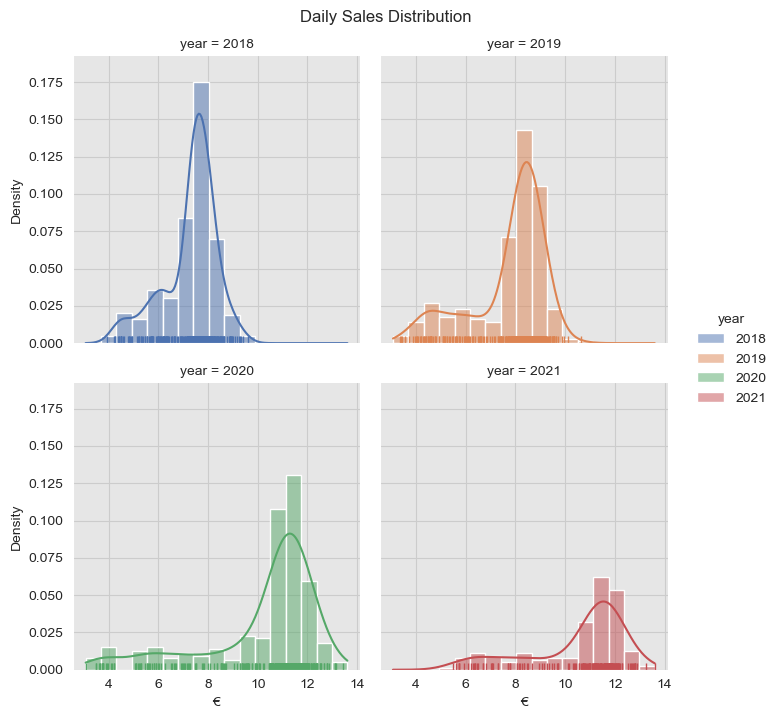

In [10]:
g = sns.displot(
    x='sales',
    data=data_df.assign(year= lambda x: x['year'].astype('str')),
    rug=True,
    kde=True,
    stat='density',
    col='year',
    col_wrap=2,
    hue='year',
    height=3.5
)
g.set_axis_labels('€')
g.fig.suptitle('Daily Sales Distribution', y=1.02);

### Seasonality

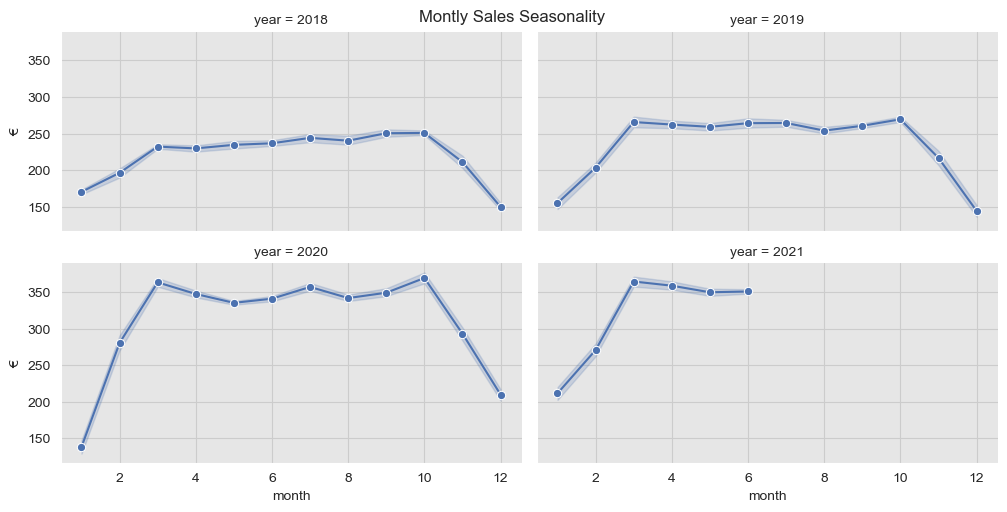

In [11]:
g = sns.relplot(
    data=data_df,
    x='month', 
    y='sales', 
    col='year', 
    kind='line', 
    estimator='sum',
    marker='o',
    col_wrap=2, 
    height=2.5, 
    aspect=2, 
    legend=True
)
g.set_axis_labels('month', '€')
g.fig.suptitle('Montly Sales Seasonality');

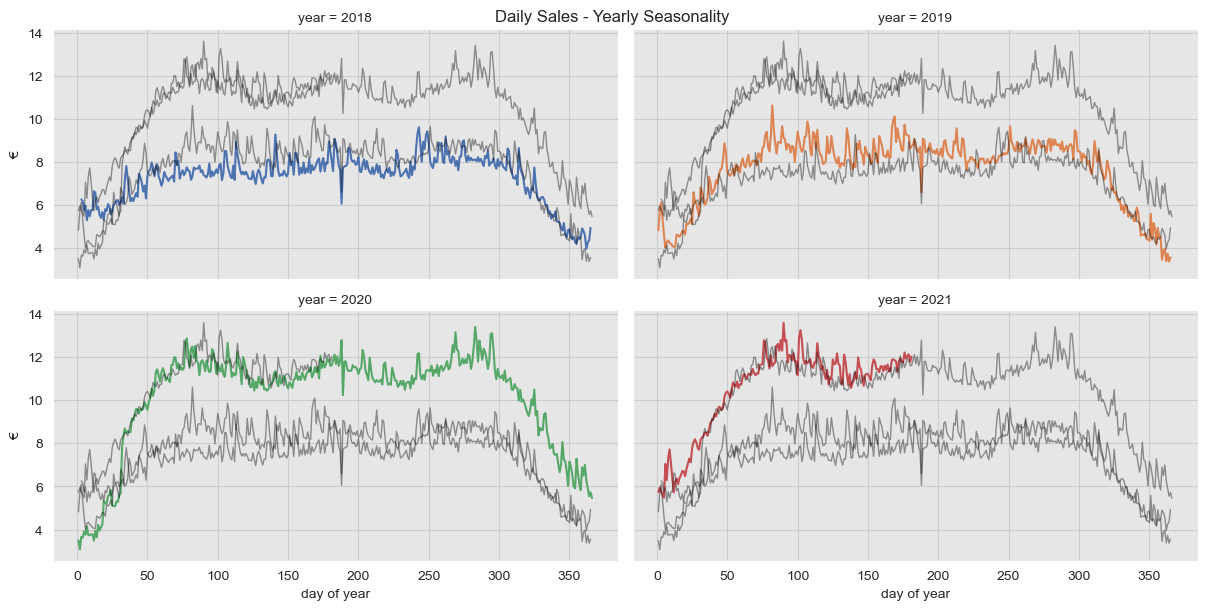

In [12]:
g = sns.relplot(
    data=data_df,
    x='dayofyear', 
    y='sales', 
    col='year', 
    hue='year',
    palette=sns_c[:4],
    kind='line', 
    estimator=None,
    col_wrap=2, 
    height=3, 
    aspect=2, 
    legend=False
)

for year, ax in g.axes_dict.items():
    # Plot every year's time series in the background.
    sns.lineplot(
        x='dayofyear', 
        y='sales', 
        data=data_df.query(f'year != {year}'),
        units='year',
        estimator=None, 
        color='black', 
        alpha=0.4,
        linewidth=1, 
        ax=ax
    )

g.set_axis_labels('day of year', '€')
g.fig.suptitle('Daily Sales - Yearly Seasonality');

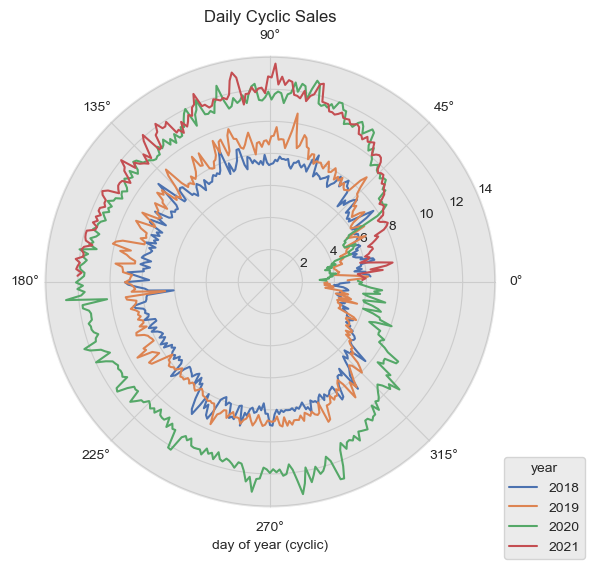

In [13]:
ax = plt.subplot(111, projection='polar')

data_df \
    .assign(
        day_of_year_cyclic = lambda x: x['dayofyear'].transform(lambda x: 2*np.pi*x/365.5),
        year = lambda x: x['year'].astype('str')
    ) \
    .pipe((sns.lineplot, 'data'), 
        x='day_of_year_cyclic', 
        y='sales', 
        hue='year',
        ax=ax
    )

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0))
ax.set(title='Daily Cyclic Sales', ylabel='', xlabel='day of year (cyclic)');

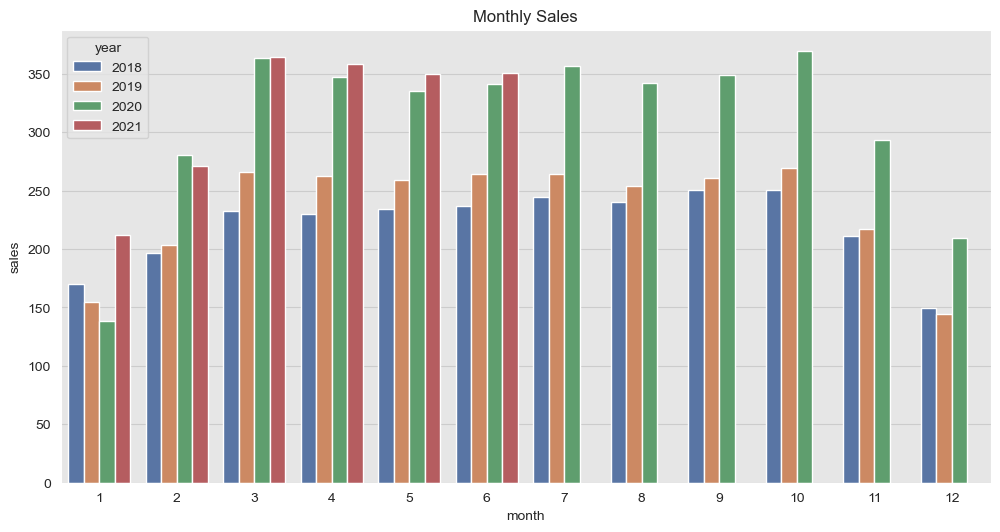

In [14]:
fig, ax = plt.subplots()
data_df \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .pipe((sns.barplot, 'data'), 
        x='month', 
        y='sales', 
        hue='year', 
        ax=ax
    )
ax.set(title='Monthly Sales');

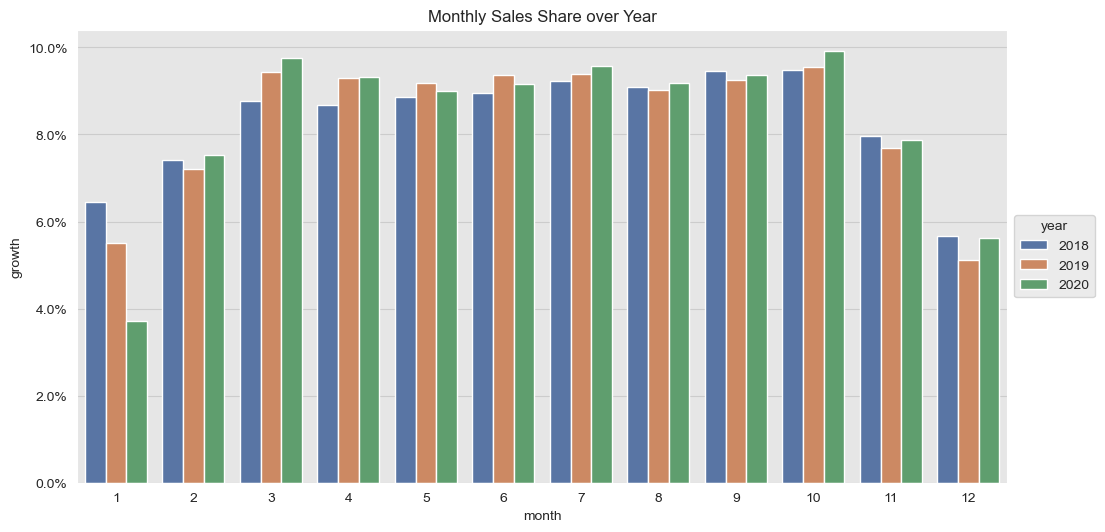

In [15]:
fig, ax = plt.subplots()
data_df \
    .query('year < 2021') \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .assign(
        yearly_sales = lambda x: x.groupby('year')['sales'].transform(np.sum), 
        montly_sales_share = lambda x: x['sales'].div(x['yearly_sales'])
    ) \
    .pipe((sns.barplot, 'data'), 
        x='month', 
        y='montly_sales_share', 
        hue='year',
        ax=ax
    )
ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set(title='Monthly Sales Share over Year', ylabel='growth');

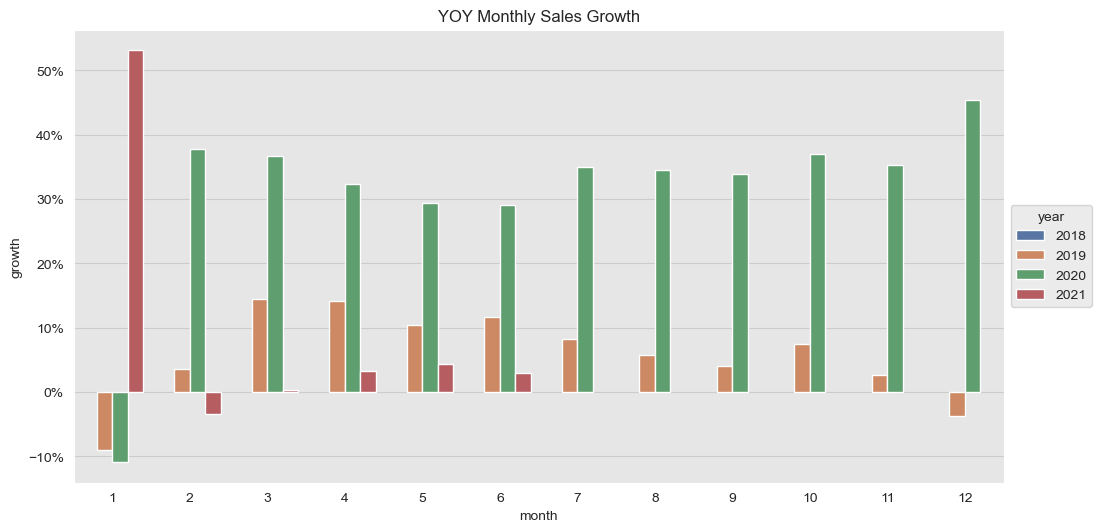

In [16]:
fig, ax = plt.subplots()
data_df \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .sort_values(['month', 'year']) \
    .assign(
        sales_lag = lambda x: x.groupby('month')['sales'].transform('shift'),
        yoy_monthly_growth = lambda x: x['sales'].div(x['sales_lag']) - 1
    ) \
    .pipe((sns.barplot, 'data'), 
        x='month', 
        y='yoy_monthly_growth', 
        hue='year', 
        ax=ax
    )
ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set(title='YOY Monthly Sales Growth', ylabel='growth');

### Many Variables

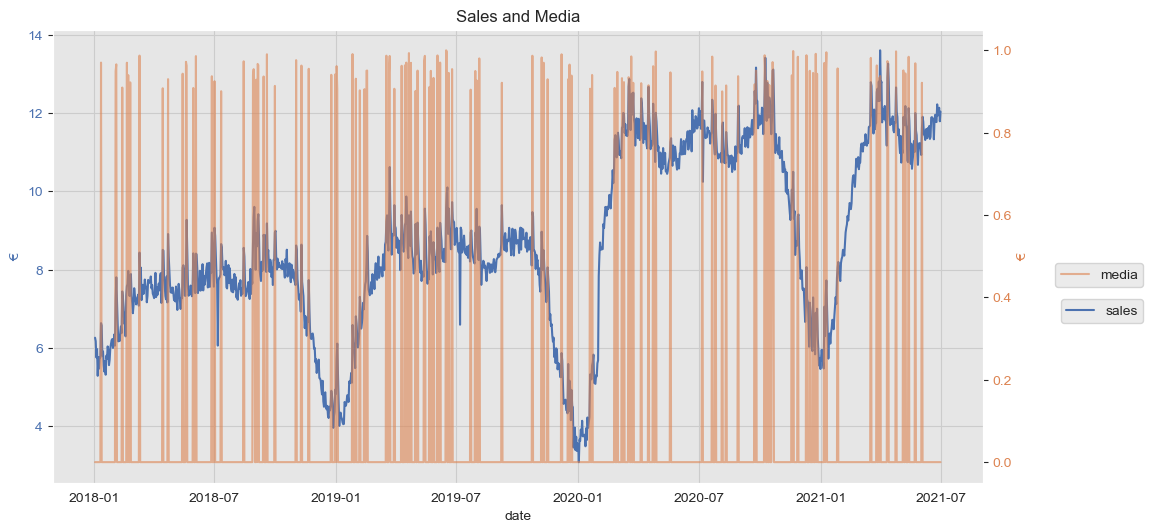

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(x='date', y='sales', data=data_df, color=sns_c[0], label='sales', ax=ax1)
sns.lineplot(x='date', y='media', data=data_df, color=sns_c[1], alpha=0.6, label='media', ax=ax2)
ax1.legend(bbox_to_anchor=(1.18, 0.42))
ax2.legend(bbox_to_anchor=(1.18, 0.5))
ax1.tick_params(axis='y', labelcolor=sns_c[0])
ax1.set_ylabel('y', fontdict={'color': sns_c[0]})
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[1])
ax2.set_ylabel('€', fontdict={'color': sns_c[1]});
ax1.set(title='Sales and Media', xlabel='date', ylabel='€');

## Missing Values

### Generate Mssing Values

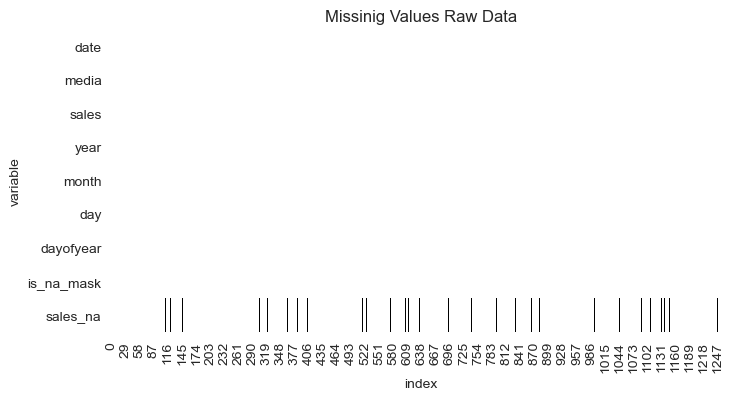

In [18]:
# Generate missnig values. 
data_df['is_na_mask'] = np.random.binomial(n=1, p=0.05, size=data_df.shape[0]).astype('bool')
data_df = data_df.assign(sales_na = lambda x: np.where(x['is_na_mask'], np.nan, x['sales']))

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(data=data_df.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missinig Values Raw Data', xlabel='index', ylabel='variable');

In [19]:
data_df.query('sales_na.isnull()').shape[0]

70

In [20]:
np.round(data_df.query('sales_na.isnull()').shape[0] / data_df.shape[0], 4)

0.0549

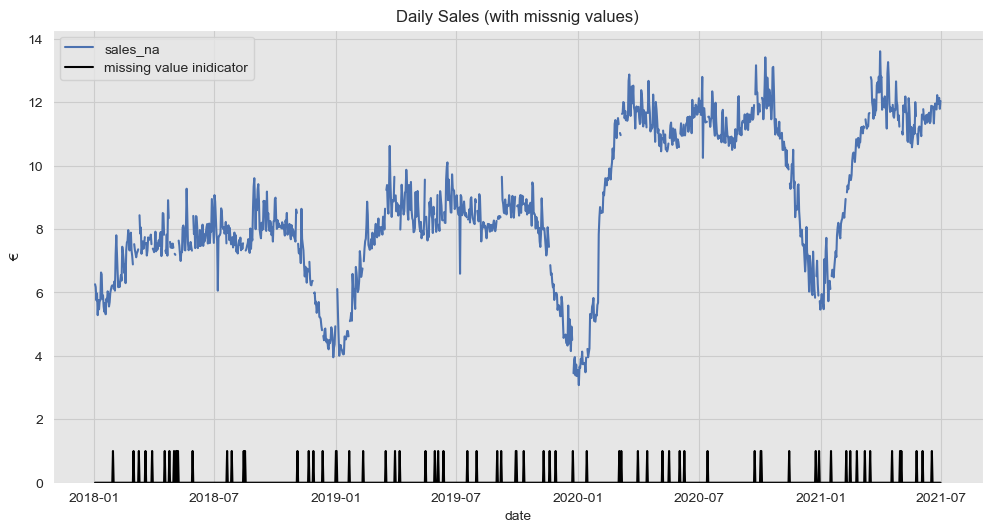

In [21]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales_na', data=data_df, color=sns_c[0], label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=data_df, color='black', label='missing value inidicator',ax=ax)
ax.set(title='Daily Sales (with missnig values)', xlabel='date', ylabel='€', ylim=(0, None));

### Fill Missnig Values

In [22]:
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

data_df = data_df = data_df.assign(
    sales_na_zero = lambda x: SimpleImputer(fill_value=0.0, strategy='constant').fit_transform(x[['sales_na']]),
    sales_na_mean = lambda x: SimpleImputer(strategy='mean').fit_transform(x[['sales_na']]),
    sales_na_median = lambda x: SimpleImputer(strategy='median').fit_transform(x[['sales_na']]),
    sales_na_most_frequent = lambda x: SimpleImputer(strategy='most_frequent').fit_transform(x[['sales_na']]),
    sales_na_last = lambda x: x['sales_na'].fillna(method='ffill'),
    sales_na_knn = lambda x: KNNImputer(n_neighbors=3, weights='distance').fit_transform(x[['sales_na', 'day', 'month', 'year']])[:, 0],
    sales_na_iterative = lambda x: IterativeImputer().fit_transform(x[['sales_na', 'day', 'month', 'year']])[:, 0]
)

ImportError: cannot import name 'IterativeImputer' from 'sklearn.impute' (/Users/juanitorduz/opt/anaconda3/envs/btsa/lib/python3.7/site-packages/sklearn/impute/__init__.py)

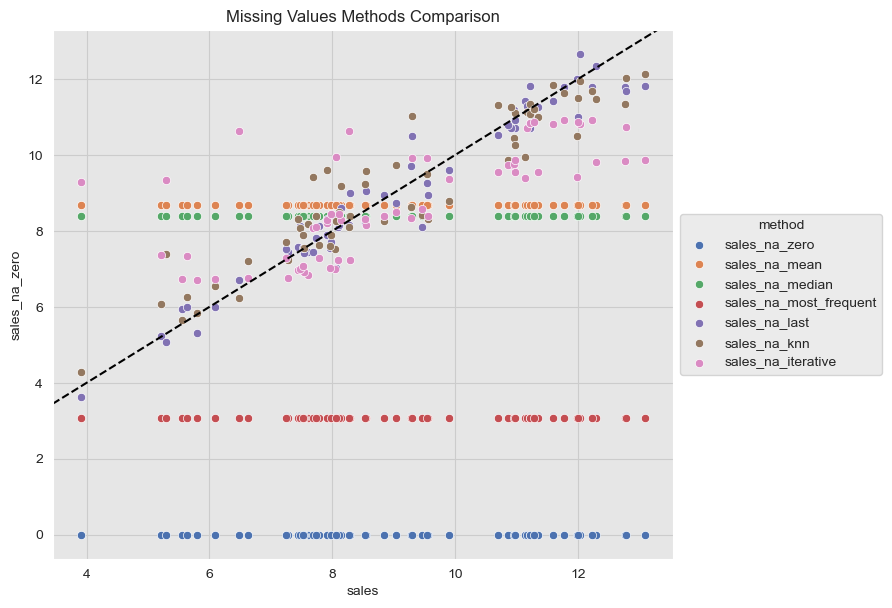

In [138]:
fig, ax = plt.subplots(figsize=(8, 7))
for i, col in enumerate(data_df.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='sales',
        y=col,
        data=data_df.query('sales_na.isnull()'),
        color=sns_c[i],
        label=col,
        ax=ax
    )
ax.axline(xy1=(4, 4), slope=1, color='black', linestyle='--')
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Missing Values Methods Comparison');

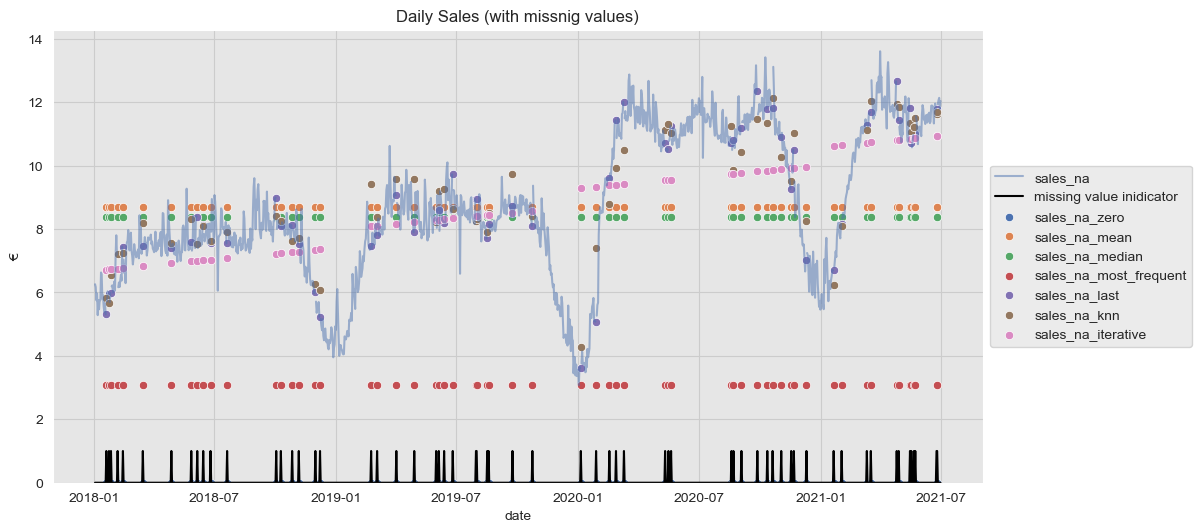

In [140]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales_na', data=data_df, color=sns_c[0], alpha=0.5, label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=data_df, color='black', label='missing value inidicator',ax=ax)
for i, col in enumerate(data_df.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='date',
        y=col,
        data=data_df.query('sales_na.isnull()'),
        color=sns_c[i],
        label=col,
        ax=ax
    )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Daily Sales (with missnig values)', xlabel='date', ylabel='€', ylim=(0, None));

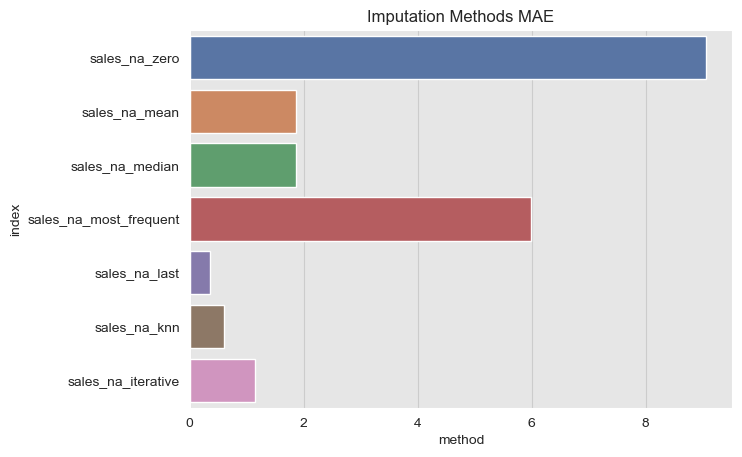

In [171]:
from sklearn.metrics import mean_absolute_error

mae_dict = {}
for col in data_df.filter(regex='sales_na_').columns:
    mae_dict[col] = mean_absolute_error(
        y_true=data_df.query('sales_na.isnull()')['sales'], 
        y_pred=data_df.query('sales_na.isnull()')[col]
    )

fig, ax = plt.subplots(figsize=(7, 5))
pd.DataFrame \
    .from_dict(mae_dict, orient='index', columns=['mae']) \
    .reset_index(drop=False) \
    .pipe((sns.barplot, 'data'),
        y='index', 
        x='mae',
        ax=ax
    )
ax.set(title='Imputation Methods MAE', xlabel='method');